# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Name: Justin Balwan
Pace: 60-Week-Pace
Project Review:
Instructor Name: Abhineet Kulkarni
Blog post URL:

# Overview

## The Business Problem Problem

As an employee for a real estate agency, I am analyzing information from the Kings County House Sales dataset. Given several factors from the dataset, I aim to provide advice to my agency on how home renovations will increase the values of homes in Kings County; more specifically, I aim to determine which home renovation factors are the most lucrative. By understanding which factors increase a home's value, my agency will be able to successfully help homeowners sell their homes for a maximized profit.

- Which home renovation factors are most lucrative in increasing a home's value?


In [586]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report



from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [587]:
df = pd.read_csv('data/kc_house_data.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Data Understanding

From the data given, I want to further explore how my target variable "price" is represented in the Kings County Data Set by investigating its measures of central tendency. 

In [588]:
target_variable = df['price']

In [589]:
print(target_variable.describe())

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64


From the above, we can see that ...

- The mean, or average, home price of a house in Kings County is $540,296

- The median home price $450,000

Below, I will compute a histogram to visualize this descrption.

Text(0, 0.5, 'Number of Homes')

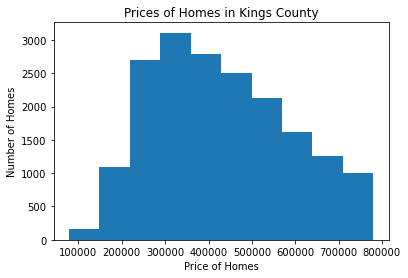

In [590]:
plt.hist(target_variable.loc[target_variable < 780000])
plt.title('Prices of Homes in Kings County')
plt.xlabel('Price of Homes')
plt.ylabel('Number of Homes')
# I use .loc to better visualize the data
# It is set to < 780,000 because the maximum value of a home is 770,000

## Data Cleaning

From the original dataset, I am choosing to drop columns that will not contribute to the end goal.

- id
- date
- waterfront
- view
- grade
- sqft_above
- sqft_basement
- yr_renovated
- zipcode
- lat
- long
- sqft_living15
- sqft_lot15

In [591]:
df.drop(columns = ['id', 'date', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], inplace=True)

Below shows the variables, or home renovation factors, that I will be using. These factors are suitable for this task because I will need to determine which of them will be the most lucrative. In turn, this will increase the value of homes in Kings County.

In [592]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built
0,221900.0,3,1.00,1180,5650,1.0,Average,1955
1,538000.0,3,2.25,2570,7242,2.0,Average,1951
2,180000.0,2,1.00,770,10000,1.0,Average,1933
3,604000.0,4,3.00,1960,5000,1.0,Very Good,1965
4,510000.0,3,2.00,1680,8080,1.0,Average,1987
...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,Average,2009
21593,400000.0,4,2.50,2310,5813,2.0,Average,2014
21594,402101.0,2,0.75,1020,1350,2.0,Average,2009
21595,400000.0,3,2.50,1600,2388,2.0,Average,2004


In [593]:
continuous = ['price',
              'sqft_living',
              'sqft_lot',
              'yr_built',
             ]

categorical = ['condition',
               'bedrooms', # you cannot easily change the number of bedrooms; it's fixed
               'floors', # number of floors are set in a house; difficult to change
               'bathrooms',
              ]
#price	bedrooms	bathrooms	sqft_living	sqft_lot	floors	condition	yr_built

#### Categorical Variables

I will compute histograms to depict my categorical factors first, along with knowing how many of each home renovation factors there are for each.

Categories
condition (5): ['Average' 'Very Good' 'Good' 'Poor' 'Fair']
bedrooms (12): [ 3  2  4  5  1  6  7  8  9 11 10 33]
floors (6): [1.  2.  1.5 3.  2.5 3.5]
bathrooms (29): [1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75 6.25
 6.5 ]


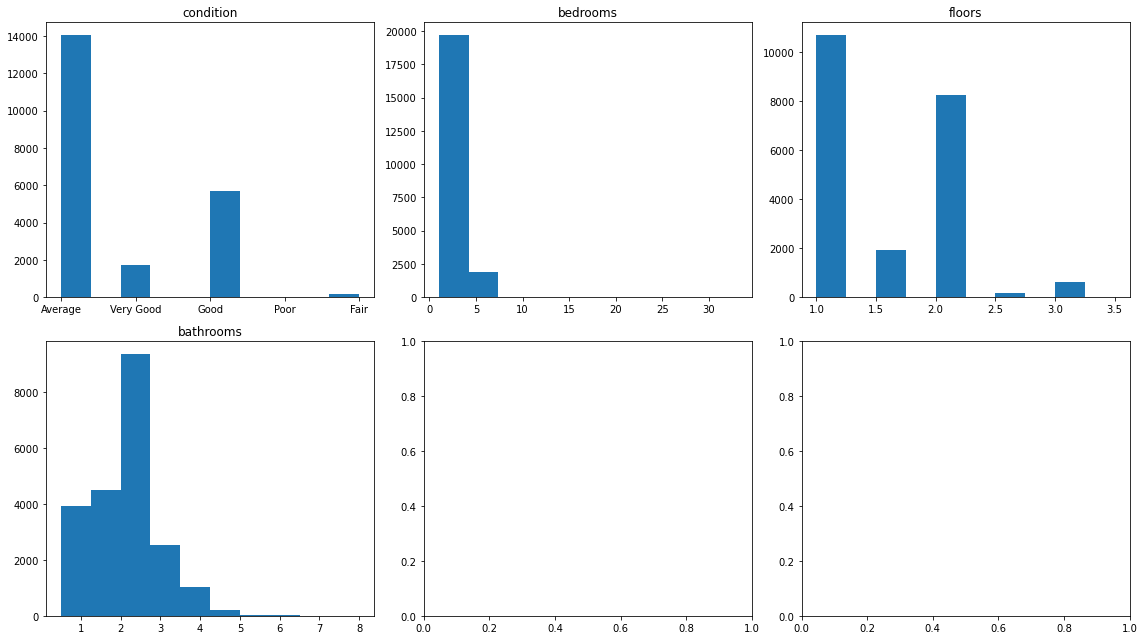

In [594]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(16,9))

for col, ax in zip(categorical, axes.flatten()):
    ax.hist(df[col])
    ax.set_title(col)
    
fig.tight_layout()
#print the name and number of each category, followed by the names of the categories therein
print('Categories')
for each in categorical:
    print('{} ({}): {}'.format(each, df[each].nunique(), df[each].unique()))
    #nunqiue returns the length of the array of the unique values for each column
    #unique returns an array of the unique values for each column

Interesting results! We can see that ... 
- There are 5 types of home conditions
- There are 12 types of bedrooms sizes
- There are 6 types/levels of floors
- There are 29 types of bathroom sizes


More specifically ... 
- Most homes have an average condition
- Most homes have < 5 bedrooms
- Most homes have 1-2 floors
- Most homes have between 2-3 bathrooms

#### Continuous Variables

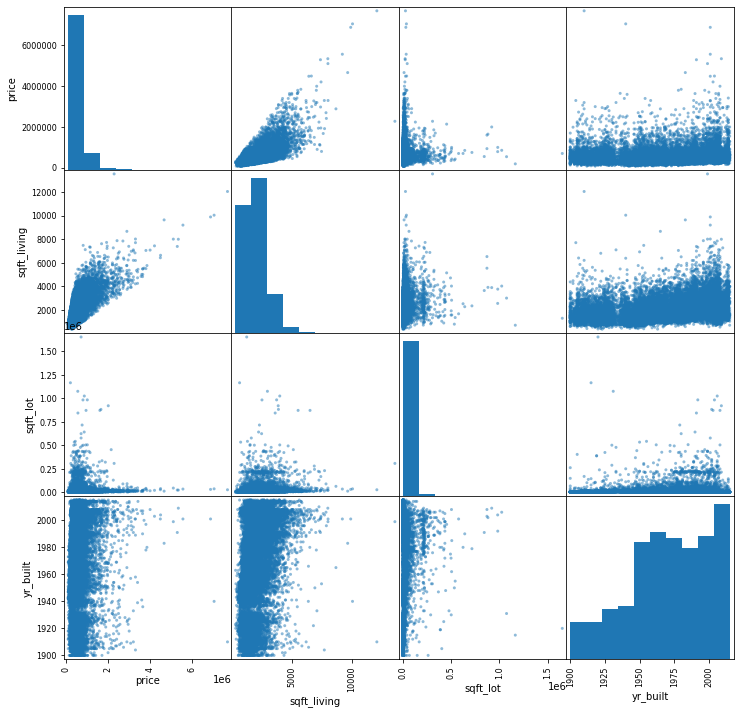

In [595]:
#Creating a scatter matrix to depict the continuous data
pd.plotting.scatter_matrix(df[continuous], figsize=(12,12))
plt.show()

What can we determine from this data? <Examine the first column!>

- Square foot of living has a STRONG correlation with price; we can assume that as the square foot of living increases, so does price.
- Square foot of lot has a high number of 0's. What does this mean? Does this indicate apartment building homes, which is more expansive vertically rather than horizontally (compared to regular flat homes), thus requiring not that much square foot of lot?
- Generally same number of homes were built from 1900-2000; interesting to note that as the year increased, more homes began increasing in price; it is vaguely right skewed.

## Data Preparation

Let's examine our target variable once more:

Text(0, 0.5, 'Number of Homes')

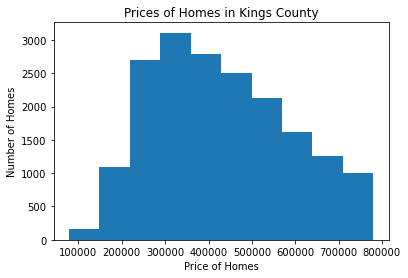

In [596]:
plt.hist(target_variable.loc[target_variable < 780000])
plt.title('Prices of Homes in Kings County')
plt.xlabel('Price of Homes')
plt.ylabel('Number of Homes')
# I use .loc to better visualize the data
# It is set to < 780,000 because the maximum value of a home is 770,000

Our target variable, "price", appears to be right skewed.

Below, I have implemented the "train vs test" process as mentioned earlier in the lectures and in the final topic cumulative lab. I will use the test set to evaluate the performance of my model, as I am trying to predict the future homes prices that have not yet been determined. The model below will just be based on the train set.

#### Train vs. Test

In [597]:
#Splitting the data into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), df['price'], test_size= 0.20, random_state=340)


print('Training data shapes: X = {}, y ={}'.format(X_train.shape, y_train.shape))
print('Test data shapes: X = {}, y ={}'.format(X_test.shape, y_test.shape))

Training data shapes: X = (17277, 7), y =(17277,)
Test data shapes: X = (4320, 7), y =(4320,)


In [598]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built
5425,2,1.00,1790,15783,1.0,Good,1959
10833,2,0.75,850,7710,1.0,Very Good,1909
10794,3,2.50,1430,9240,2.0,Average,1984
3779,4,2.50,2080,9846,1.0,Average,1984
18571,4,1.75,1320,7694,1.0,Average,1928
...,...,...,...,...,...,...,...
247,2,1.50,720,5120,1.0,Average,1954
5553,4,2.75,2660,7754,1.5,Average,1986
17442,3,1.75,1490,5000,1.0,Average,1954
16345,4,3.50,4010,10880,2.0,Good,1990


In [621]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 5425 to 8836
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     17277 non-null  int64  
 1   bathrooms    17277 non-null  float64
 2   sqft_living  17277 non-null  int64  
 3   sqft_lot     17277 non-null  int64  
 4   floors       17277 non-null  float64
 5   condition    17277 non-null  object 
 6   yr_built     17277 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.1+ MB


As mentioned earlier, our target variable, "price", is right skewed. To conform/revert this skewed variable back to normality, I will perform a log transformation.

(array([1.4463e+04, 2.3550e+03, 3.2300e+02, 8.9000e+01, 3.2000e+01,
        9.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  78000.,  759200., 1440400., 2121600., 2802800., 3484000.,
        4165200., 4846400., 5527600., 6208800., 6890000.]),
 <BarContainer object of 10 artists>)

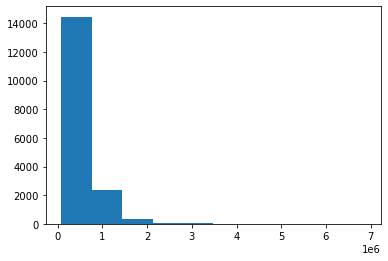

In [600]:
#Print the histogram of untransformed target variable
plt.hist(y_train)

In [601]:
#Performing log transformations and apply to dataframes
# Y = target variable / outcome desired
y_train_log = y_train.map(lambda x: np.log(x))
log_train = pd.concat([y_train_log, X_train], axis = 1)
y_test_log = y_test.map(lambda x: np.log(x))
log_test = pd.concat([y_test_log, X_test], axis = 1)

(array([6.100e+01, 4.670e+02, 2.944e+03, 5.670e+03, 5.042e+03, 2.217e+03,
        6.480e+02, 1.810e+02, 4.200e+01, 5.000e+00]),
 array([11.26446411, 11.71257586, 12.16068761, 12.60879937, 13.05691112,
        13.50502287, 13.95313463, 14.40124638, 14.84935814, 15.29746989,
        15.74558164]),
 <BarContainer object of 10 artists>)

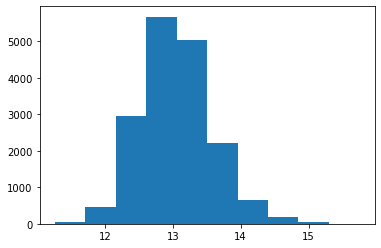

In [602]:
#Print histogram to see results
# We use Y_Train to train the model, while Y_Test confirms if it works or not
plt.hist(y_train_log)

It looks more like a bell-curve now; more normal!

To find out the correlation of the variables in regards to the target variable "price":

In [603]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.053953
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.155670
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.507173
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.318152
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.052946
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.489193
yr_built,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,1.000000


It appears that "price" vs. "sqft_living" is the most correlated, but let's check to make sure!

To double check this result, I will build a heatmap to visualize the correlation.

#### Building a Correlation Heatmap to Create a Baseline Model

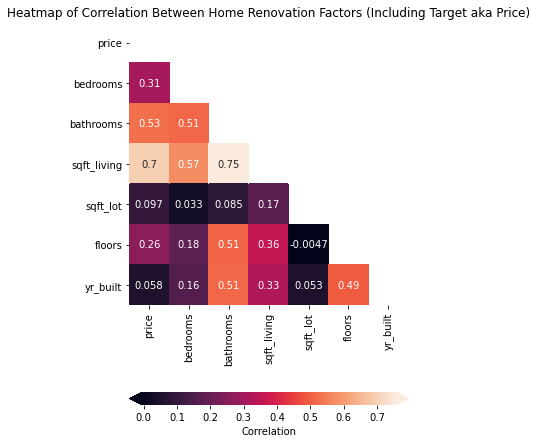

In [604]:
import seaborn as sns
import numpy as np

# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(5, 8))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Home Renovation Factors (Including Target aka Price)");

In [605]:
most_correlated_feature = "sqft_living"

Square foot of living is the most correlated feature! The heat map result matches the result found from df.corr()

Let's create a scatter plot to investigate the correlation further.

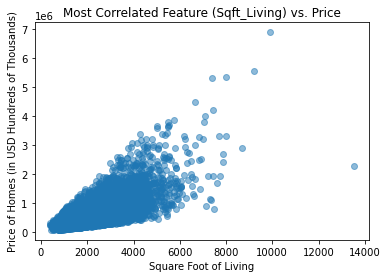

In [606]:
fig, ax = plt.subplots()

ax.scatter(X_train[most_correlated_feature], y_train, alpha=0.5)
ax.set_xlabel('Square Foot of Living')
ax.set_ylabel("Price of Homes (in USD Hundreds of Thousands)")
ax.set_title("Most Correlated Feature (Sqft_Living) vs. Price");

In [607]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()

In [608]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.4859445613109424
Validation score: 0.49118981553004265


This appears to be a very strong model. The training subsets are not far off from the validation subsets (about .2 off).






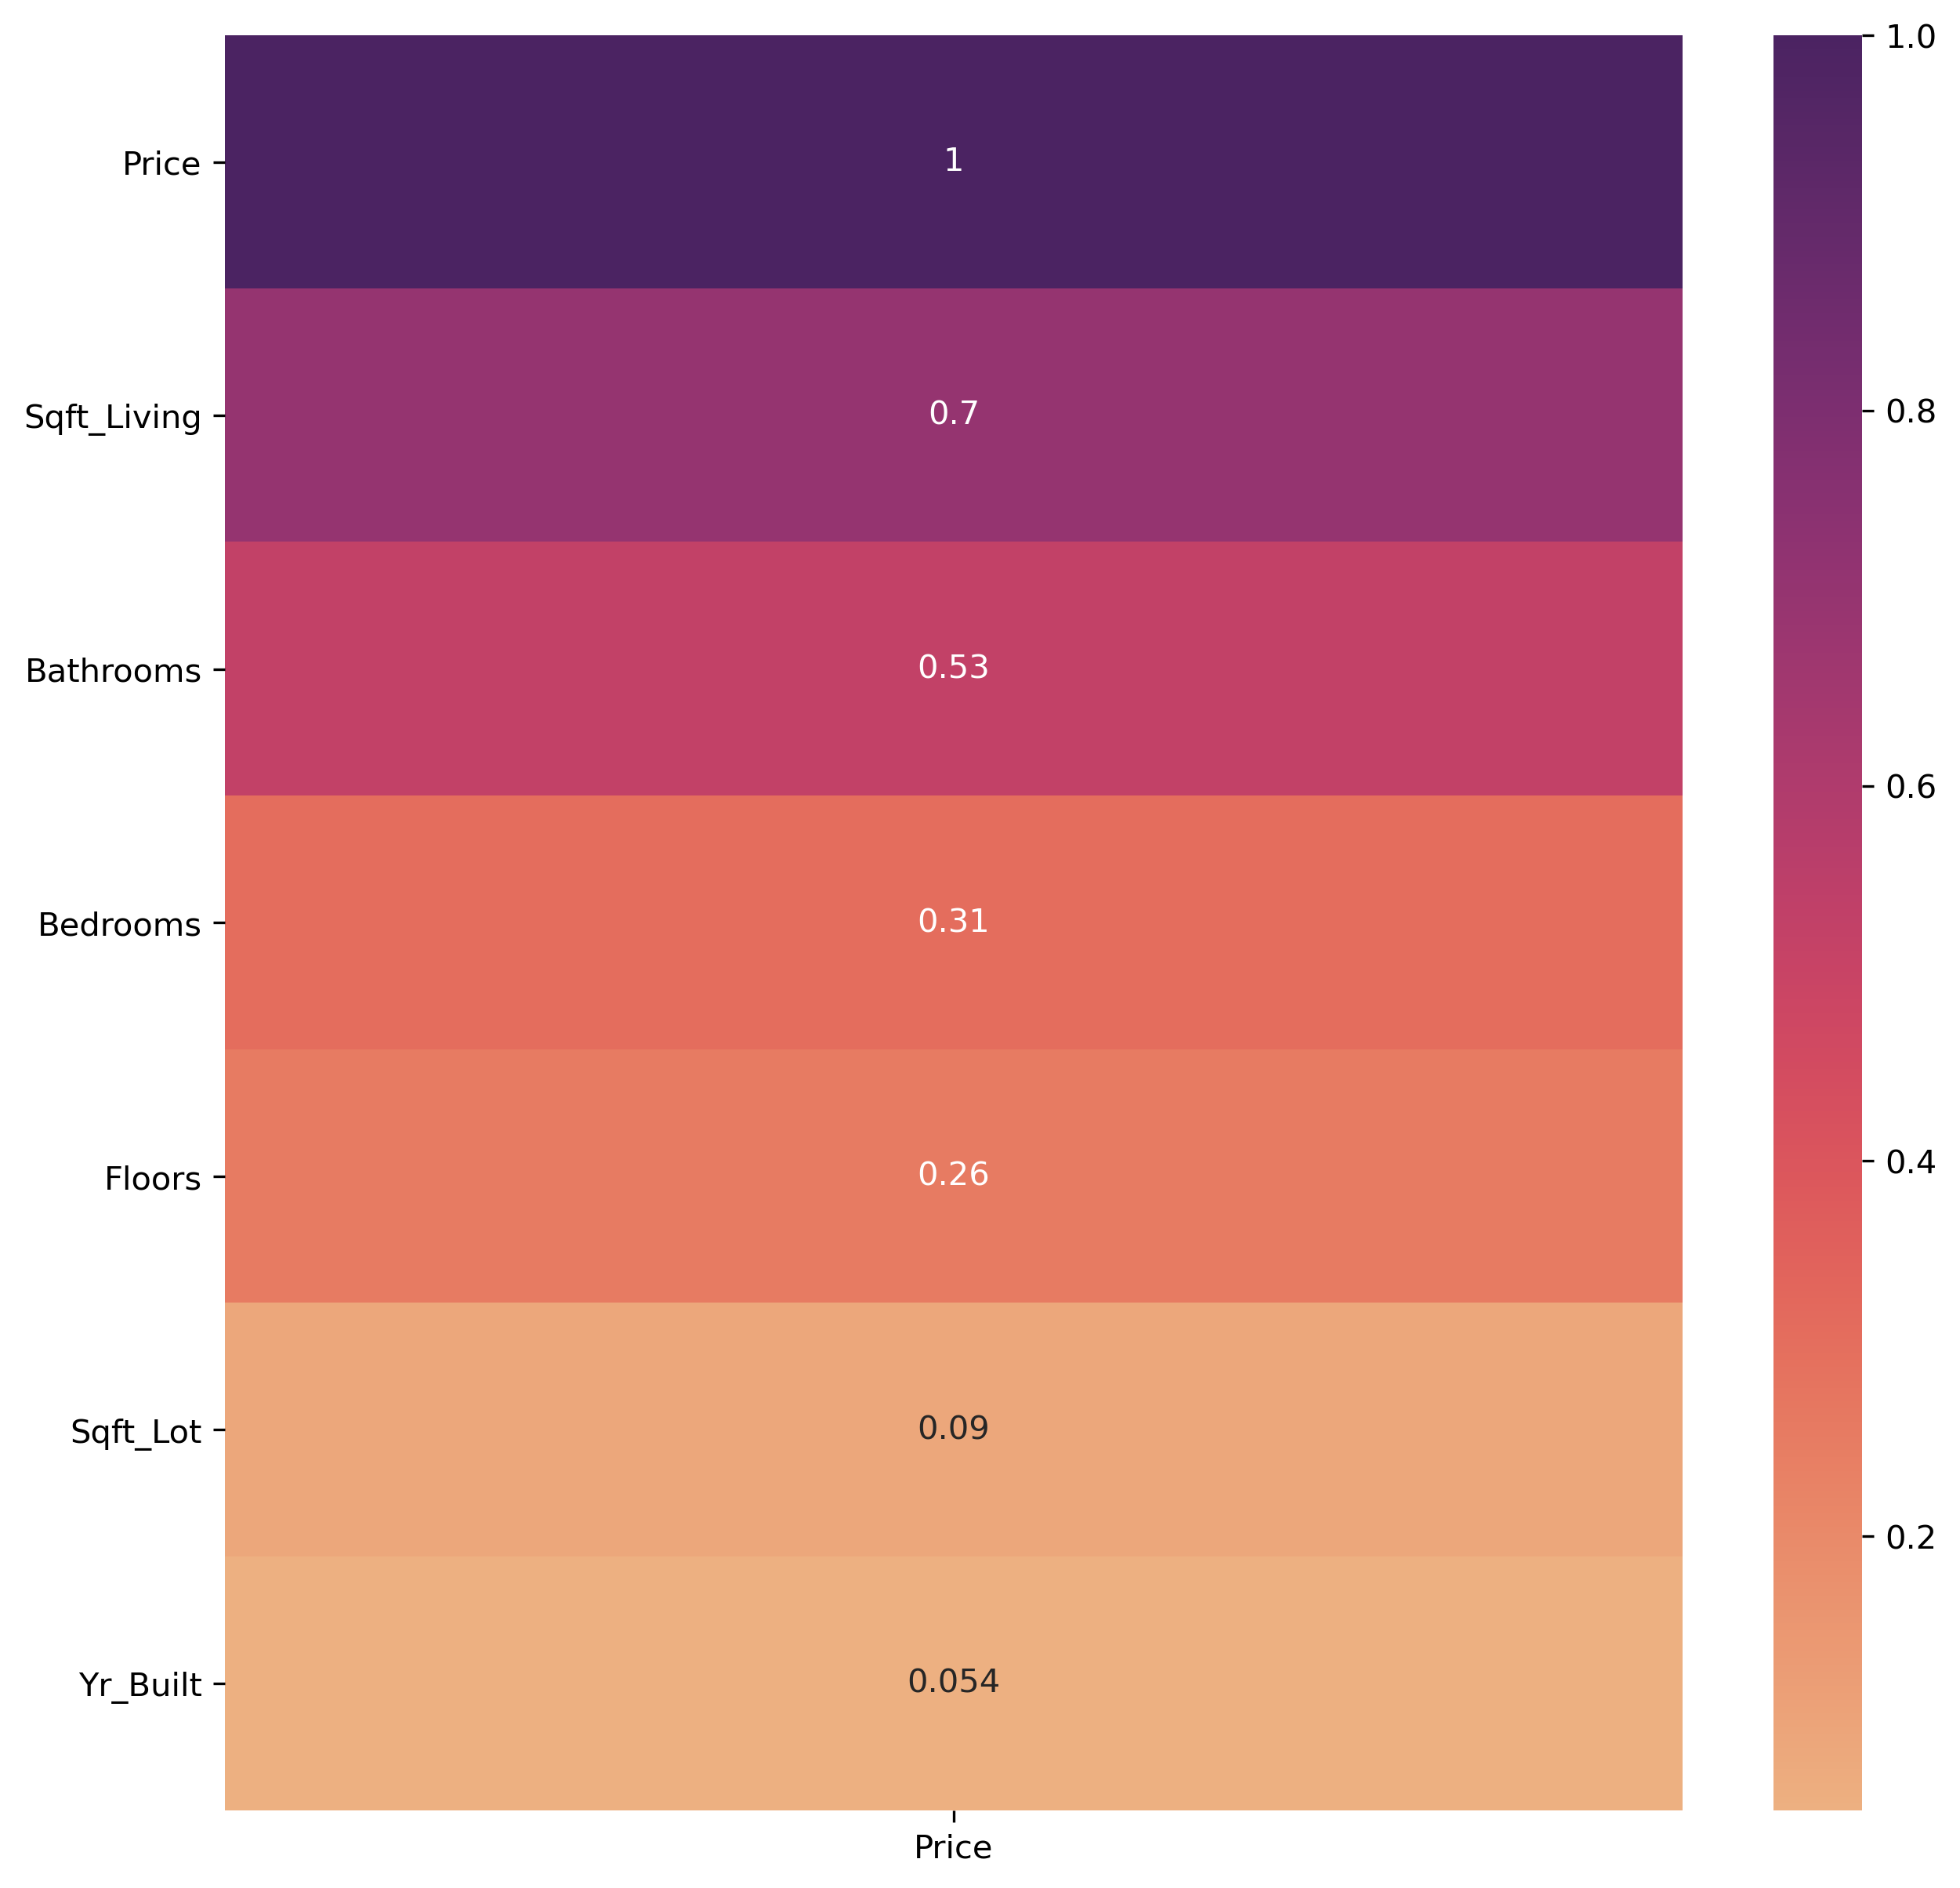

In [636]:
# Placing correlation in order (from strongest to weakest)
indx = df.corr().sort_values('price', ascending=False).index
df_sorted = df.loc[:, indx]

plt.figure(figsize=(10,10), dpi=300)
sns.heatmap(df_sorted.corr()[['price']],
            cmap="flare",
            xticklabels=['Price'],
            yticklabels=['Price', 'Sqft_Living', 'Bathrooms', 'Bedrooms',
                         'Floors', 'Sqft_Lot', 'Yr_Built'],
            annot=True)
plt.yticks(rotation=0);

# Will use this in presentation

I would say there is not high multicollineraity; I do not see independent variables that are highly correlated with one another.

Below, I will create a scatter matrix to show the numerous non-normal distributions that exist.

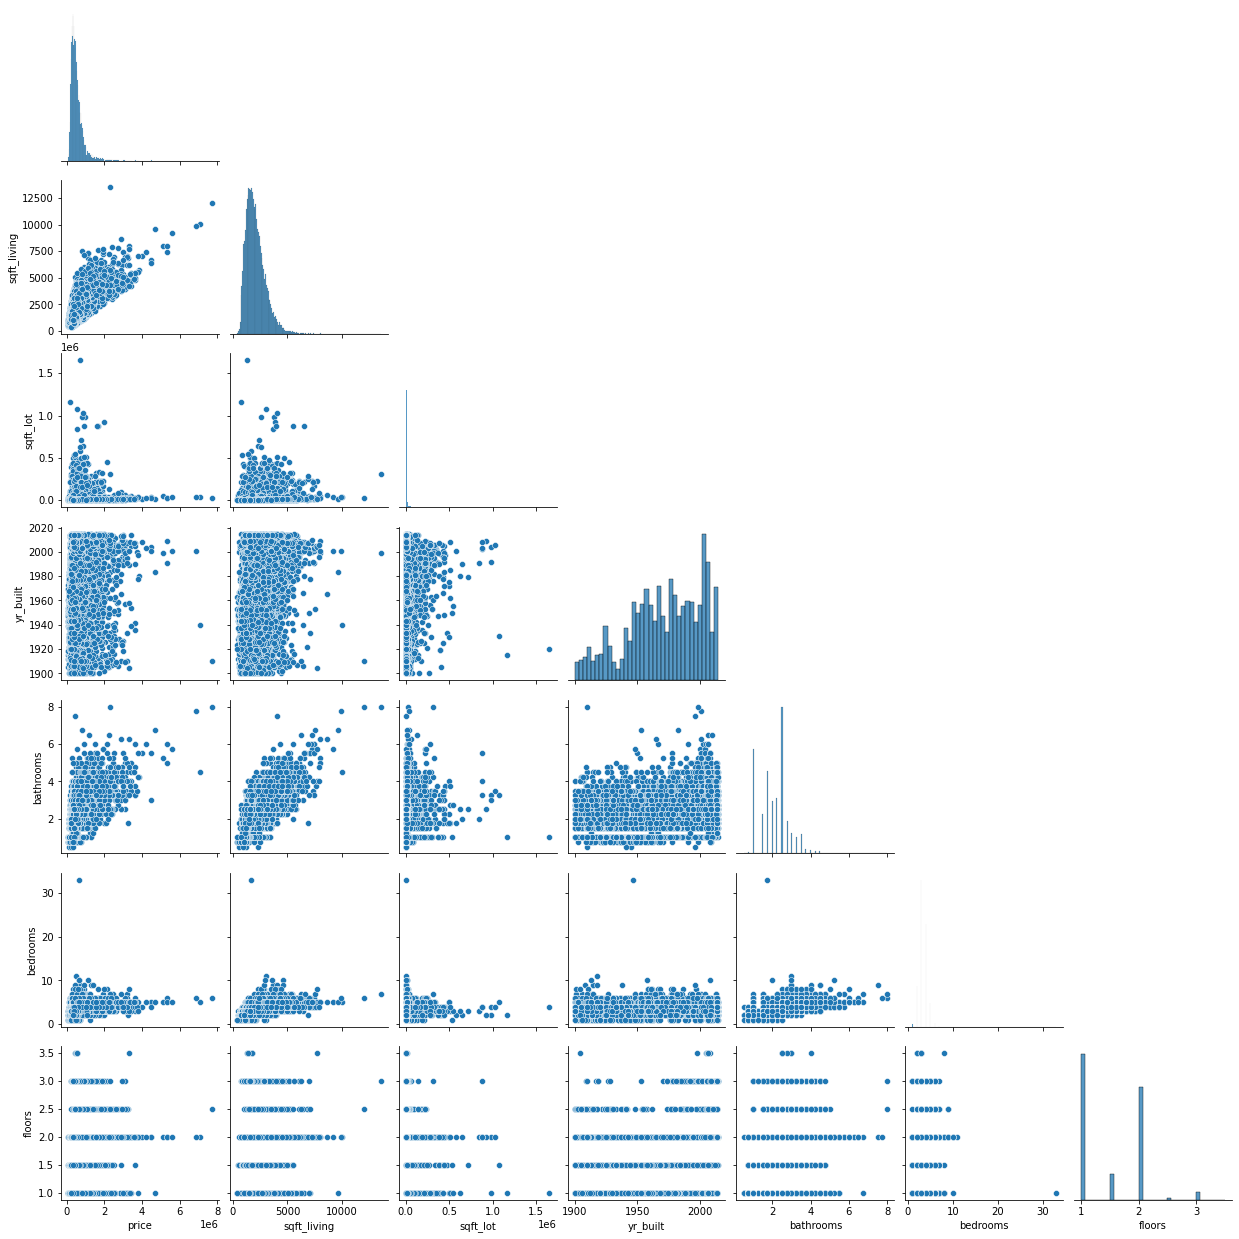

In [629]:
scatter_columns = ['price',
              'sqft_living',
              'sqft_lot',
              'yr_built',
              'bathrooms',
                # 'condition', it's a categorical variable; will not be displayed
               'bedrooms',
               'floors', ]

df_scatter = df[scatter_columns]
sns.pairplot(df_scatter, corner=True);

## Modeling

#### Creating a Baseline Model

The baseline model allows us to take the factors we selected from the Kings County housing dataset and predict the future home prices.

In [611]:
# Importing necessary packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [612]:
regression = LinearRegression()

Formula taken from the practice done with the 'ames_housing' dataset.

In [613]:
df_cont = df[continuous]

# log features
log_names = [f'{column}_log' for column in df_cont.columns]

df_log = np.log(df_cont)
df_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

df_log_norm = df_log.apply(normalize)

# one hot encode categoricals
df_ohe = pd.get_dummies(df[categoricals], prefix=categoricals)

preprocessed = pd.concat([df_cont, df_ohe], axis=1)

X = preprocessed.drop('price', axis=1)
y = preprocessed['price']

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

0.5237775937412916

The above baseline R squared value was executed using 10-fold cross-validation. The R squared computed above will be the baseline R squared value.

Checking again what our dataframe looks like:

In [614]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built
0,221900.0,3,1.00,1180,5650,1.0,Average,1955
1,538000.0,3,2.25,2570,7242,2.0,Average,1951
2,180000.0,2,1.00,770,10000,1.0,Average,1933
3,604000.0,4,3.00,1960,5000,1.0,Very Good,1965
4,510000.0,3,2.00,1680,8080,1.0,Average,1987
...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,Average,2009
21593,400000.0,4,2.50,2310,5813,2.0,Average,2014
21594,402101.0,2,0.75,1020,1350,2.0,Average,2009
21595,400000.0,3,2.50,1600,2388,2.0,Average,2004


WHY ARE WE ANALYZING OLS RESULTS?
- Models in StatsModels, including OLS, are not really designed for predictive model validation, but they do give us a lot more statistical information.


In [645]:
# Analyzing OLS results

outcome = 'price'
df1 = df.drop('price', axis=1)
predictors = '+'.join(df1.columns)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     2717.
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        01:39:32   Log-Likelihood:            -2.9859e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21586   BIC:                         5.973e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               6.306e+06   1.43e+05     44.160      0.000    6.03e+06    6.59e+06
condition[T.Fair]      -4.622e+04    1.9e+04     -2.431      0.015   -8.35e+04   -8953.872
condition[T.Good]       1.147e+04   4130.227      2.777      0.005    3374.380    1.96e+04
condition[T.Poor]       -4.89e+04   4.56e+04     -1.073      0.283   -1.38e+05    4.04e+04
condition[T.Very Good]  3.996e+04   6658.786      6.002      0.000    2.69e+04     5.3e+04
bedrooms               -6.966e+04   2254.346    -30.900      0.000   -7.41e+04   -6.52e+04
bathrooms               6.549e+04   3863.211     16.953      0.000    5.79e+04    7.31e+04
sqft_living              303.8814      2.999    101.333      0.000     298.003     309.759
sqft_lot                  -0.2967      0.041     -7.209      0.000      -0.377      -0.216
floors                   5.67e+04   3828.141     14.812      0.000    4.92e+04    6.42e+04
yr_built               -3240.6402     73.739    -43.947      0.000   -3385.175   -3096.106
==============================================================================
Omnibus:                    14394.294   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           532766.380
Skew:                           2.698   Prob(JB):                         0.00
Kurtosis:                      26.726   Cond. No.                     3.79e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.79e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Jarque-Bera, or JB, is very high, meaning there is a lot of non-normal distributions.
- There is strong multicollinearity, which contradicts my statement from earlier where I said there does not seem to be!

Let's check to make sure that there is no heteroscedasticity between "price" and "sqft_living". If there is, we must perform log transformations.

DEFINITION: Heteroscedasticity - happens when the standard deviations of a predicted variable, monitored over different values of an independent variable or as related to prior time periods, are non-constant (creating a funnel-like shape rather than a flat, spread out shape due to constant outputs).

In [649]:
# OLS between 'price' and 'sqft_living'
f = 'price~sqft_living'
model = ols(f, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        01:44:37   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- There is an indication of strong multicollinerarity.
After further research, I learned that multicollinerarity may exist with the problem of heteroscedasticity. Let's check for the latter via plots:

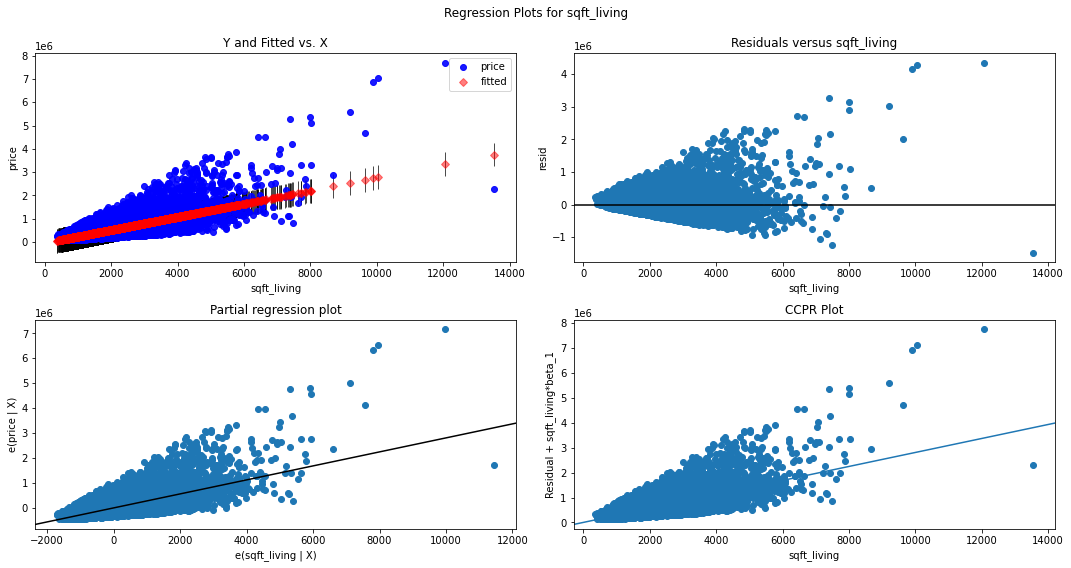

In [650]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living', fig=fig);

No heteroscedasticity found from the output (it would tell us), but it still looks somewhat like a 'funnel' shape. Let's just do log transformations to put myself at ease.

In [651]:
# Normalizing distribution using log transformation

df2 = df.copy()
df2['price_log'] = np.log(df2['price'])
df2['sqft_living_log'] = np.log(df2['sqft_living'])
df2 = df2.drop(['price', 'sqft_living'], axis=1)

# Create an OLS between 'price_log' and 'sqft_living_log'

f = 'price_log~sqft_living_log'
model = ols(f, df2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        01:51:59   Log-Likelihood:                -10231.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21595   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7234      0.047    142.612      0.000       6.631       6.816
sqft_living_log     0.8376      0.006    134.368      0.000       0.825       0.850
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

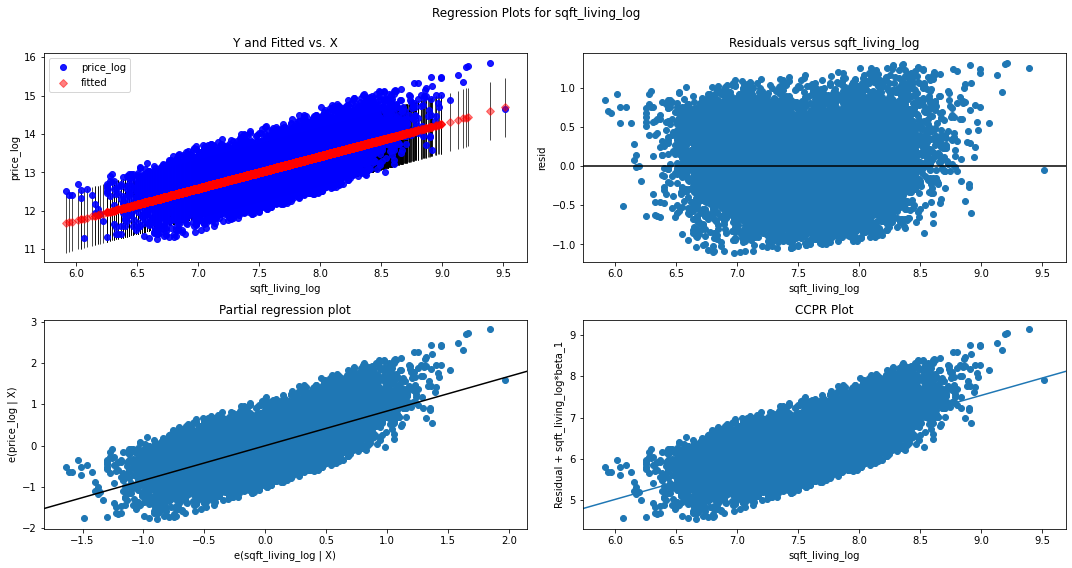

In [652]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living_log', fig=fig);

There is less of a funnel shape, so we are not violating the homoscedasticity assumption.